In [70]:
# load python packages
import numpy as np
import pandas as pd
import xarray as xr

# load machine learning packages
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import scale

# minisom package for SOM
!pip install minisom
import minisom
from minisom import MiniSom

from pylab import bone, pcolor, colorbar, plot, show
from matplotlib.patches import Patch


In [101]:
# customize figure 
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams["axes.unicode_minus"] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['hatch.linewidth'] = 2.5

# Importing data from disk

In [19]:
path='./'
dust_df = pd.read_csv(path+'saharan_dust_met_vars.csv', index_col='time')

# print out shape of data 
print('Shape of data:', np.shape(dust_df))

# print first 5 rows of data
print(dust_df.head())
feature_names = dust_df.columns

Shape of data: (18466, 10)
                 PM10         T2        rh2         slp       PBLH  RAINC  \
time                                                                        
1960-01-01  2000.1490  288.24875  32.923786  1018.89420  484.91812    0.0   
1960-01-02  4686.5370  288.88450  30.528862  1017.26575  601.58310    0.0   
1960-01-03  5847.7515  290.97128  26.504536  1015.83514  582.38540    0.0   
1960-01-04  5252.0586  292.20060  30.678936  1013.92230  555.11860    0.0   
1960-01-05  3379.3190  293.06076  27.790462  1011.94934  394.95440    0.0   

            wind_speed_10m  wind_speed_925hPa       U10       V10  
time                                                               
1960-01-01        6.801503          13.483623 -4.671345 -4.943579  
1960-01-02        8.316340          18.027075 -6.334070 -5.388977  
1960-01-03        9.148216          17.995173 -6.701636 -6.227193  
1960-01-04        8.751743          15.806478 -6.387379 -5.982842  
1960-01-05        6.39322

# Scaling the variables

As you can see there is a large range of values bewteen variables. To not influence the results as it is the case in many unsupervised machine learning models, it is important to scale them. Many scaling methods exist but I am using the minmax scaler.

In [64]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (-10,10))
sc.fit(dust_df)
scaled_dust_df = sc.transform(dust_df)

# Define map and train the SOM map

In [67]:
#for num in ([10, 20, 30]):
# Define minisom model
num = 20
som = MiniSom(x=num, # map size
              y=num, # map size, NxN
              input_len=10, # 10 element input vectors
              sigma=10.,
              learning_rate=0.5, 
              neighborhood_function='gaussian' # a few options for this
             )

# input_len: number of features used for training the model
# sigma: is the radius of the different neighbors in the SOM
# learning rate: determines how much the weights are adjusted during each iterations

# initilize weights using PCA
# You could also do that using random_weights_init, but the advantage is that PCA is likely to converge faster
#som.pca_weights_init(scaled_dust_df)  # prefrerred
som.random_weights_init(scaled_dust_df)

## training the SOM : there are two type of training
# 1. train_random: trains model by pickinhg random data from the data
# 2. train_batch: trains model from samples in the order in which they are fed.

som.train(data = scaled_dust_df, num_iteration = 3000, 
          random_order=True, verbose=True)

 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 4.798516582941136


# Visualizing the Results

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax = ax.flatten()
for i, f in enumerate(feature_names):
    #plt.subplot(5, 2, i+1)
    ax[i].set_title(titles[i])
    ax[i].pcolor(W[:,:,i].T, cmap='coolwarm')
    #ax[i].set_xticks(np.arange(num+1))
    #ax[i].set_yticks(np.arange(num+1))

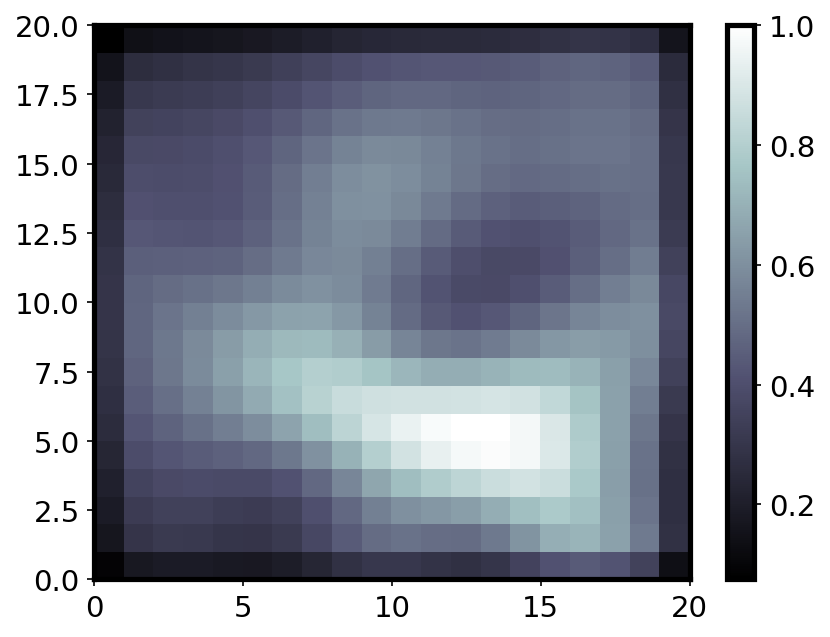

In [105]:
bone()
pcolor(som.distance_map().T)
colorbar()

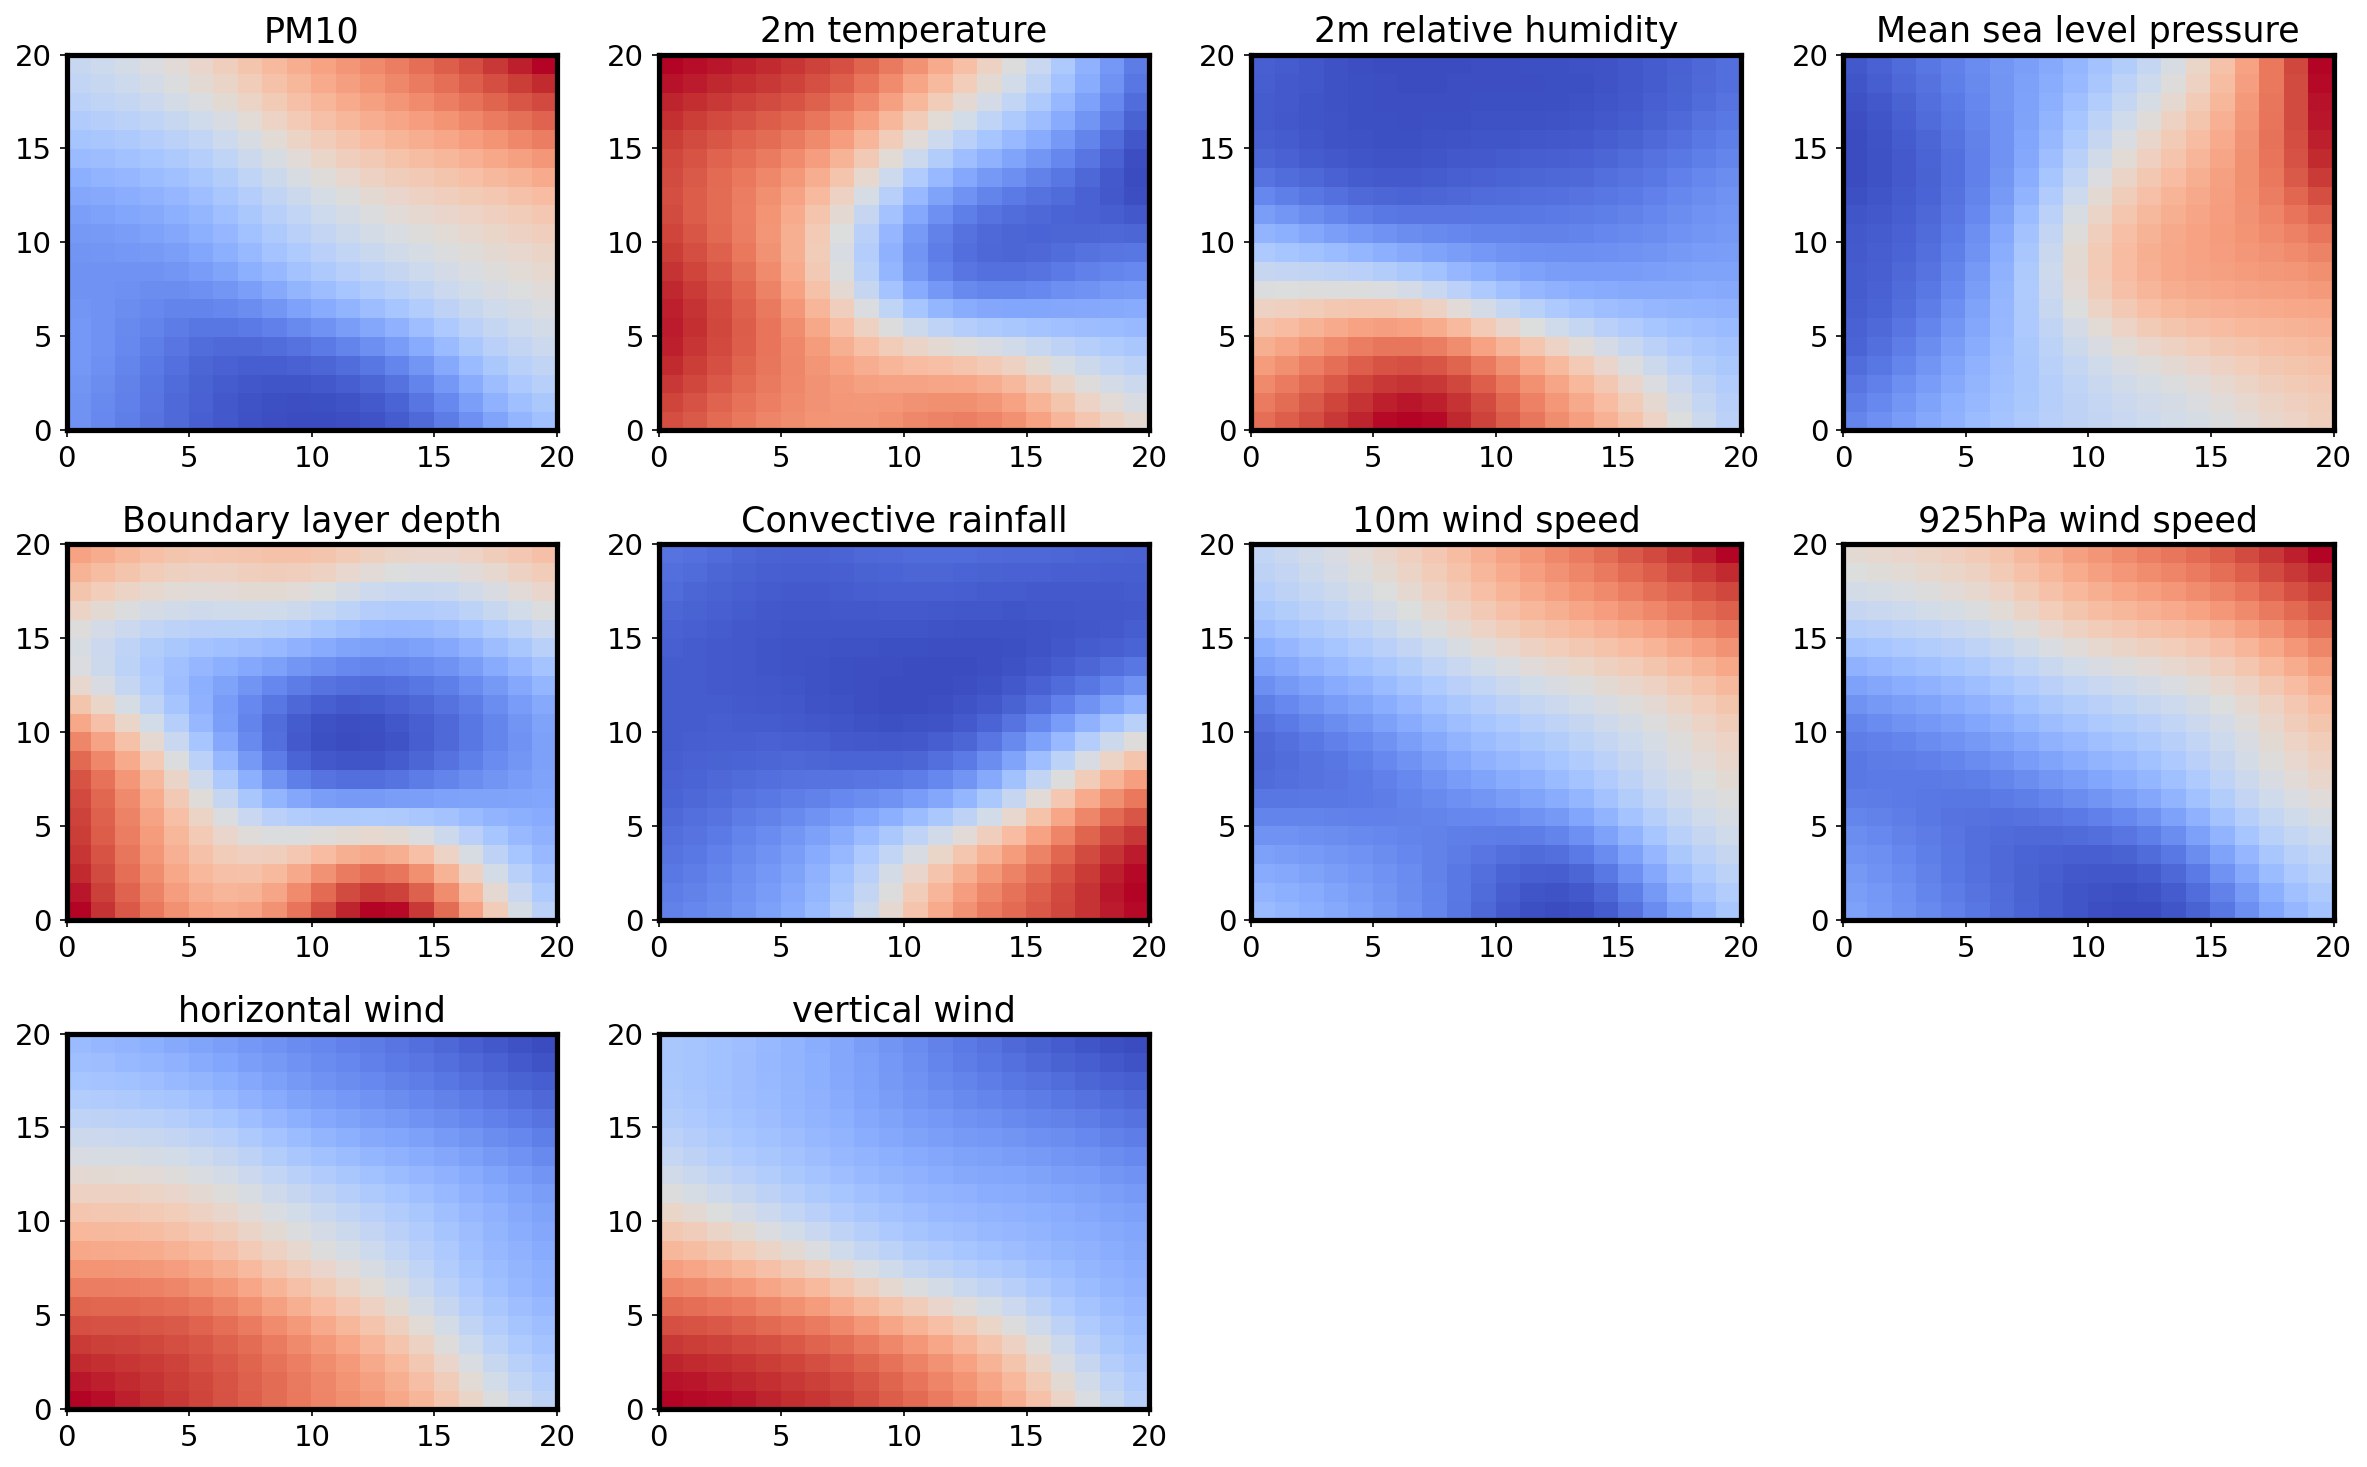

In [104]:
titles = ['PM10', '2m temperature', '2m relative humidity', 'Mean sea level pressure', 'Boundary layer depth', 
          'Convective rainfall', '10m wind speed', '925hPa wind speed', 'horizontal wind', 'vertical wind']
W = som.get_weights()
fig, ax = plt.subplots(3, 4, figsize=(16, 10))
ax = ax.flatten()
for i, f in enumerate(feature_names):
    #plt.subplot(5, 2, i+1)
    ax[i].set_title(titles[i])
    ax[i].pcolor(W[:,:,i].T, cmap='coolwarm')
    #ax[i].set_xticks(np.arange(num+1))
    #ax[i].set_yticks(np.arange(num+1))
ax[10].set_axis_off()
ax[11].set_axis_off()
plt.tight_layout()
plt.savefig('feature_importance.png')

/tmp/ipykernel_776/3902853783.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot([j+.5], [i+.5], 'o', color='C'+str(feature),


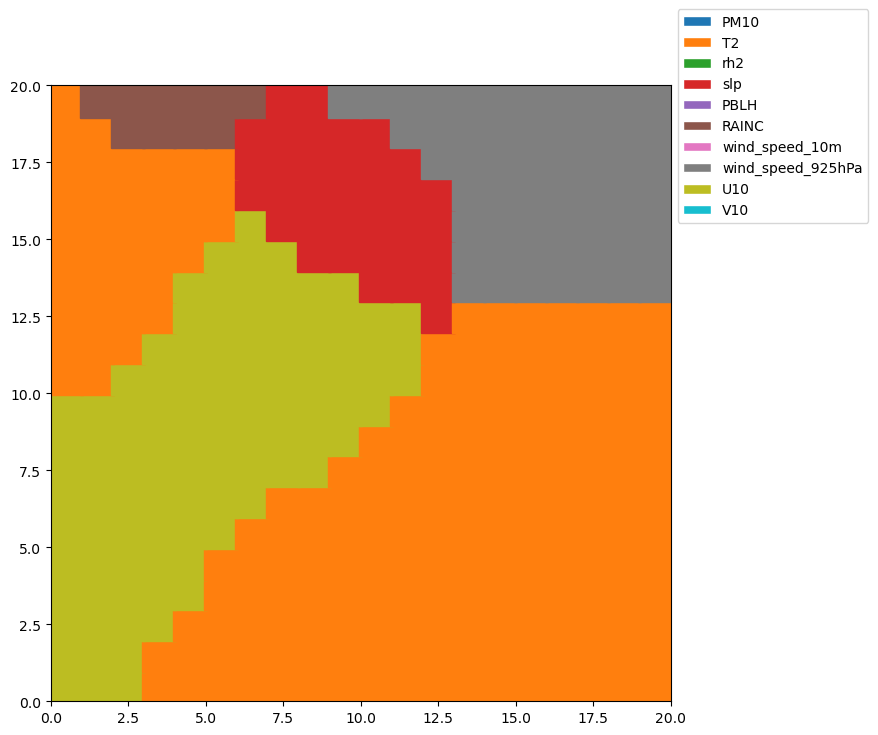

In [77]:
Z = np.zeros((num, num))
cols = np.array(['sandybrown', 'red', 'darkgreen', 'steelblue', 'magenta', 'lighseagreen', 'blue', 'slateblue', 'orange',
                'darkorange'])
plt.figure(figsize=(8, 8))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([j+.5], [i+.5], 'o', color='C'+str(feature),
                 marker='s', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .95))
        
plt.xlim([0, num])
plt.ylim([0, num])
plt.show()

In [90]:
# clusters = [som.winner(data) for data in dust_df[:5000].values]
# clu = [(cl1+1)*(cl2+1) for cl1, cl2 in clusters]
# plt.plot(clu)
# print(clu)

In [42]:
dust_df[:365].values

array([[ 2.0001490e+03,  2.8824875e+02,  3.2923786e+01, ...,
         1.3483623e+01, -4.6713448e+00, -4.9435790e+00],
       [ 4.6865370e+03,  2.8888450e+02,  3.0528862e+01, ...,
         1.8027075e+01, -6.3340700e+00, -5.3889766e+00],
       [ 5.8477515e+03,  2.9097128e+02,  2.6504536e+01, ...,
         1.7995173e+01, -6.7016360e+00, -6.2271934e+00],
       ...,
       [ 4.9895830e+03,  2.9514746e+02,  2.1093610e+01, ...,
         1.1132390e+01, -1.5973161e+00, -3.8983903e+00],
       [ 6.0900020e+03,  2.9484283e+02,  3.3629223e+01, ...,
         1.8745201e+01, -8.0929980e+00, -6.4008610e+00],
       [ 3.4601165e+03,  2.9586273e+02,  2.7987598e+01, ...,
         1.2267728e+01, -4.6182904e+00, -5.2522006e+00]])

In [43]:
dust_df[:365].values

array([[ 2.0001490e+03,  2.8824875e+02,  3.2923786e+01, ...,
         1.3483623e+01, -4.6713448e+00, -4.9435790e+00],
       [ 4.6865370e+03,  2.8888450e+02,  3.0528862e+01, ...,
         1.8027075e+01, -6.3340700e+00, -5.3889766e+00],
       [ 5.8477515e+03,  2.9097128e+02,  2.6504536e+01, ...,
         1.7995173e+01, -6.7016360e+00, -6.2271934e+00],
       ...,
       [ 4.9895830e+03,  2.9514746e+02,  2.1093610e+01, ...,
         1.1132390e+01, -1.5973161e+00, -3.8983903e+00],
       [ 6.0900020e+03,  2.9484283e+02,  3.3629223e+01, ...,
         1.8745201e+01, -8.0929980e+00, -6.4008610e+00],
       [ 3.4601165e+03,  2.9586273e+02,  2.7987598e+01, ...,
         1.2267728e+01, -4.6182904e+00, -5.2522006e+00]])

In [ ]:
bone()
pcolor(som.distance_map().T)
colorbar()

# markers = ['o', 's']
# colors = ['r', 'g']

# for i, x in enumerate(scaled_dust_df):
#     w = som.winner(x)
#     # w[0], w[1] will place the marker at bottom left corner of the rectangle. 
#     #Let us add 0.5 to both of these to plot the market at the center of the rectange.
#     plot(w[0] + 0.5, 
#          w[1] + 0.5,
#          #Target value 0 will have marker "o" with color "r"
#          #Target value 1 will have marker "s" with color "g"
#          marker='o', 
#          markeredgecolor = 'r',
#          markerfacecolor = 'None', #No color fill inside markers
#          markersize = 10,
#          markeredgewidth = 2)
# show()


# Random Forest Regression

In [ ]:
# Load packages
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Define a function for error calculations

In [ ]:
def regression_stats(model_fit, model_name, features_test, pred, target_test):
  #Calculate and display model error
  score = model_fit.score(features_test,target_test)
  print('\n'+model_name)
  print(f'Score : {score}')
  print(f'MAE: {mean_absolute_error(pred,target_test)}')
  print(f'RMSE : {np.sqrt(mean_squared_error(pred,target_test))}')

In [ ]:
target_vars = dust_df['PM10']   # PM10 concentration is the target variable
features = dust_df.drop(['PM10'], axis=1)  # remaining variables should be features

# split the data into 70% training and reserve 30% for testing
train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                target_vars, test_size = 0.3)

# Now train the model using the training sets
rf = RandomForestRegressor(n_estimators=200,
                    random_state=42, n_jobs=-1)
# Fit Random forest model
rf.fit(train_features, train_target)
predictions = rf.predict(test_features)

regression_stats(rf,'Random Forest',test_features, predictions, test_target)

# Variable importance

In [ ]:
# customize figure 
import matplotlib as mpl
mpl.rcParams['font.size'] = 28
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams["axes.unicode_minus"] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['hatch.linewidth'] = 2.5

In [ ]:
col_names = list(features.columns)
cols = np.array(['red', 'blue', 'green', 'cyan', 'pink', 'olive', 'purple', 'magenta',
                'indigo'])

fig, ax = plt.subplots(1,1, figsize=(22,14), sharex=False, sharey=False, 
                               constrained_layout=True) 

sorted_idx = rf.feature_importances_.argsort()
importances = rf.feature_importances_
x_values = col_names

# Make a bar chart
ax.barh(features.columns[sorted_idx], 
           importances[sorted_idx], color=cols)

ax.set_xlabel('Random Forest Feature Importance')     
ax.set_ylabel('Features')

# Hyper-parameter tuning?